Loading Required Libraries

In [ ]:
import pandas as pd

import numpy as np

**Generating mock customer data**

In [ ]:
np.random.seed(42)

num_customers = 2000



In [ ]:
import pandas as pd
import numpy as np

# Number of customers
num_customers = 2000

# Data generation
data = {
    'CustomerID': [f'CUST{1000+i}' for i in range(num_customers)],
    'Gender': np.random.choice(['Male', 'Female'], num_customers, p=[0.5, 0.5]),
    'SeniorCitizen': np.random.choice([0, 1], num_customers, p=[0.84, 0.16]),
    'Partner': np.random.choice(['Yes', 'No'], num_customers, p=[0.48, 0.52]),
    'Dependents': np.random.choice(['Yes', 'No'], num_customers, p=[0.3, 0.7]),
    'Tenure': np.random.randint(1, 73, num_customers),  # Months
    'PhoneService': np.random.choice(['Yes', 'No'], num_customers, p=[0.9, 0.1]),
    'MultipleLines': np.random.choice(['Yes', 'No', 'No phone service'], num_customers, p=[0.42, 0.48, 0.1]),
    'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], num_customers, p=[0.34, 0.44, 0.22]),
    'OnlineSecurity': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.28, 0.50, 0.22]),
    'OnlineBackup': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.34, 0.44, 0.22]),
    'DeviceProtection': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.34, 0.44, 0.22]),
    'TechSupport': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.29, 0.49, 0.22]),
    'StreamingTV': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.38, 0.40, 0.22]),
    'StreamingMovies': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.39, 0.39, 0.22]),
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], num_customers, p=[0.55, 0.24, 0.21]),
    'PaperlessBilling': np.random.choice(['Yes', 'No'], num_customers, p=[0.59, 0.41]),
    'PaymentMethod': np.random.choice(
        ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
        num_customers, p=[0.34, 0.23, 0.22, 0.21]),
    'MonthlyCharges': np.random.normal(loc=65, scale=30, size=num_customers).clip(18, 120).round(2),
}

df_customers = pd.DataFrame(data)

# Generate TotalCharges with some randomness
df_customers['TotalCharges'] = (df_customers['Tenure'] * df_customers['MonthlyCharges'] * np.random.uniform(0.95, 1.05, num_customers)).round(2)

# For customers with Tenure = 1, set TotalCharges = MonthlyCharges
df_customers.loc[df_customers['Tenure'] == 1, 'TotalCharges'] = df_customers['MonthlyCharges']

# Corrected logic for setting some TotalCharges to NaN for new customers (<3 months)
random_indices = np.random.choice(df_customers.index, size=int(num_customers * 0.01), replace=False)
mask = df_customers.index.isin(random_indices) & (df_customers['Tenure'] < 3)
df_customers.loc[mask, 'TotalCharges'] = np.nan

# Simulate churn
churn_probability = (
    0.1
    + 0.15 * (df_customers['Contract'] == 'Month-to-month')
    + 0.1 * (df_customers['InternetService'] == 'Fiber optic')
    + 0.001 * (df_customers['MonthlyCharges'] - 65)
    - 0.002 * (df_customers['Tenure'] - 36)
    + 0.1 * (df_customers['OnlineSecurity'] == 'No')
    + 0.1 * (df_customers['TechSupport'] == 'No')
)

churn_probability = np.clip(churn_probability, 0.01, 0.99)
df_customers['Churn'] = np.random.binomial(1, churn_probability, num_customers).astype(str)
df_customers['Churn'] = df_customers['Churn'].replace({'1': 'Yes', '0': 'No'})

# Clean up inconsistent labels
for col in ['MultipleLines']:
    df_customers[col] = df_customers.apply(lambda row: 'No' if row['PhoneService'] == 'No' else row[col], axis=1)

for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df_customers[col] = df_customers.apply(lambda row: 'No' if row['InternetService'] == 'No' else row[col], axis=1)

# Save to CSV
df_customers.to_csv('telecom_churn_mock_data.csv', index=False)

# Output confirmation and sample
print("Mock telecom churn data generated: telecom_churn_mock_data.csv")
print(df_customers.head())
print(f"\nChurn distribution:\n{df_customers['Churn'].value_counts(normalize=True)}")


Mock telecom churn data generated: telecom_churn_mock_data.csv
  CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0   CUST1000    Male              0      No         No      30          Yes   
1   CUST1001  Female              0      No        Yes      11          Yes   
2   CUST1002  Female              1      No         No      17           No   
3   CUST1003  Female              0     Yes         No      26          Yes   
4   CUST1004    Male              0     Yes        Yes      23          Yes   

  MultipleLines InternetService       OnlineSecurity  ... DeviceProtection  \
0           Yes              No                   No  ...               No   
1           Yes     Fiber optic  No internet service  ...               No   
2            No     Fiber optic                   No  ...               No   
3            No              No                   No  ...               No   
4            No     Fiber optic  No internet service  ...               

**Data Exploraion and Cleaning**

First 5 rows of the dataset:
  CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0   CUST1000    Male              0      No         No      30          Yes   
1   CUST1001  Female              0      No        Yes      11          Yes   
2   CUST1002  Female              1      No         No      17           No   
3   CUST1003  Female              0     Yes         No      26          Yes   
4   CUST1004    Male              0     Yes        Yes      23          Yes   

  MultipleLines InternetService       OnlineSecurity  ... DeviceProtection  \
0           Yes              No                   No  ...               No   
1           Yes     Fiber optic  No internet service  ...               No   
2            No     Fiber optic                   No  ...               No   
3            No              No                   No  ...               No   
4            No     Fiber optic  No internet service  ...               No   

           TechSupport Stre

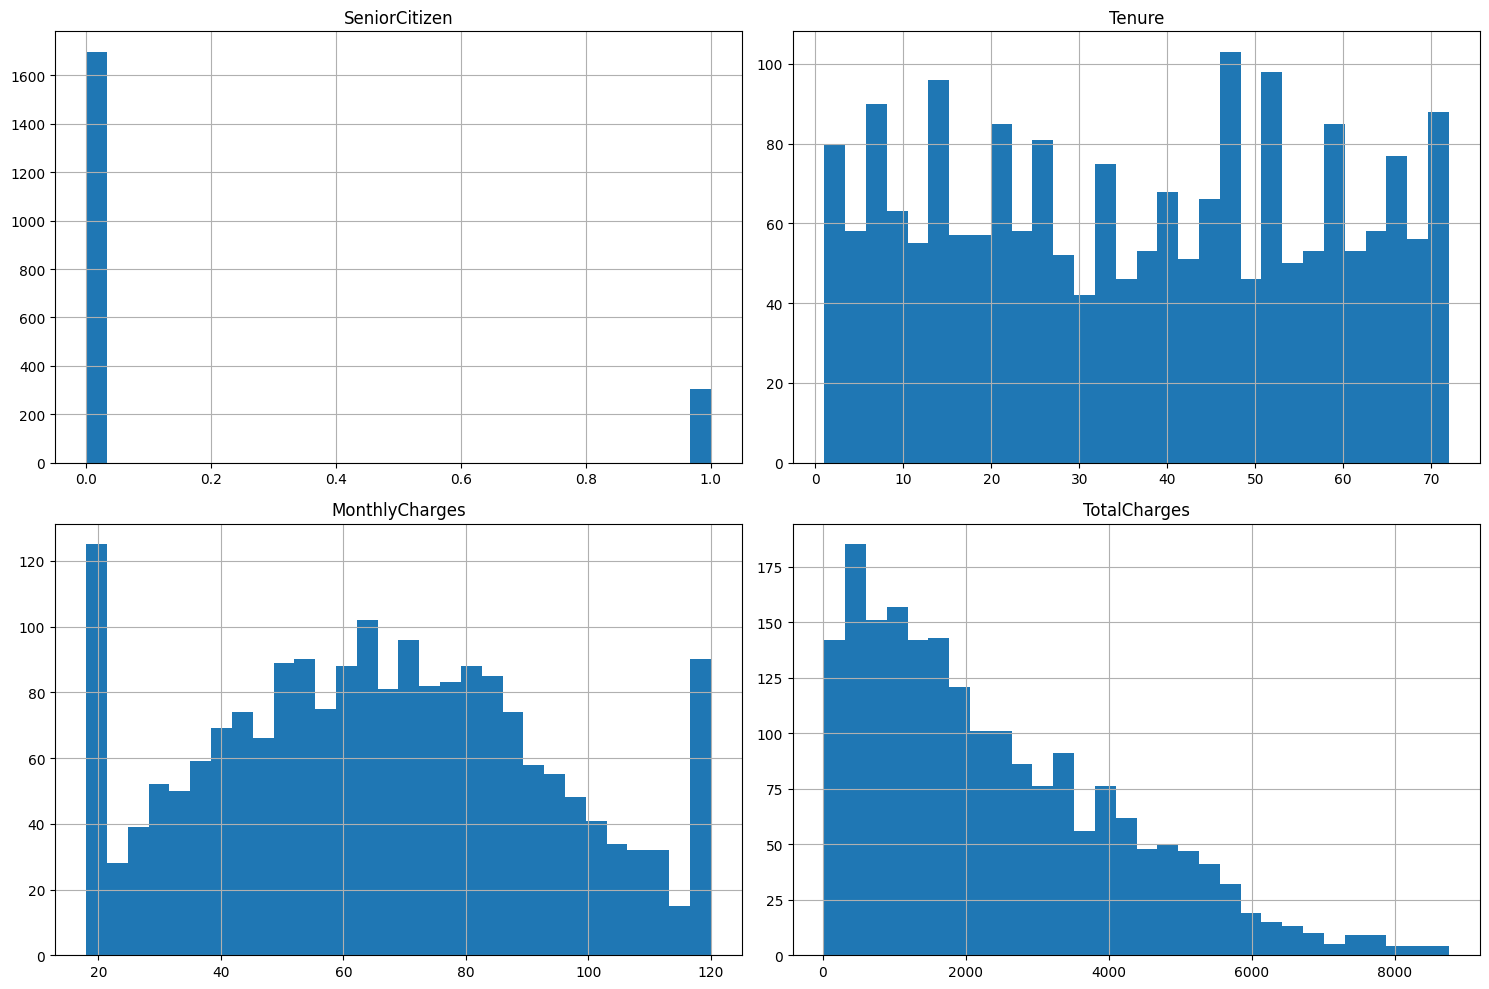

------------------------------

Visualizing distributions of categorical features:


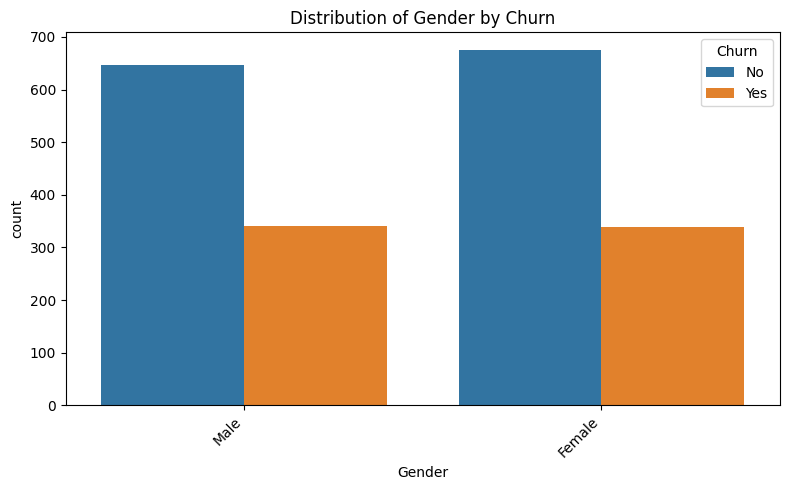

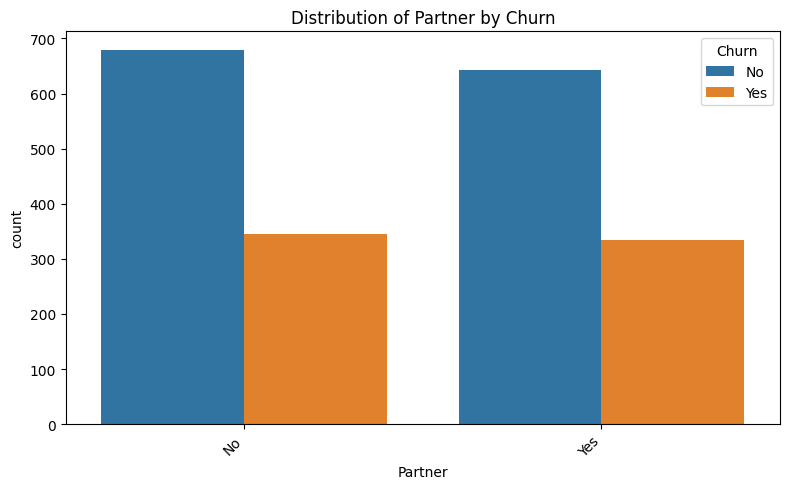

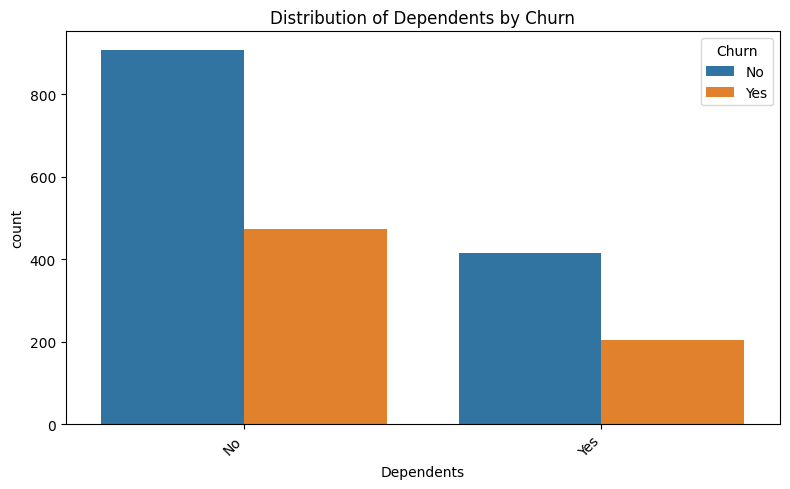

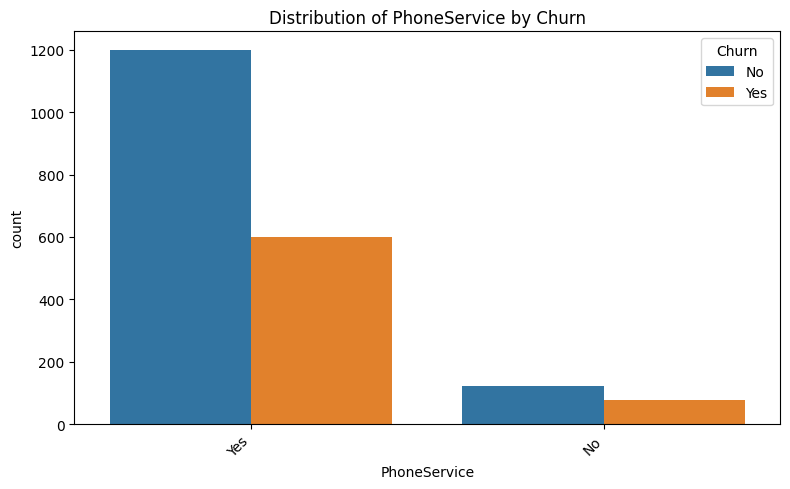

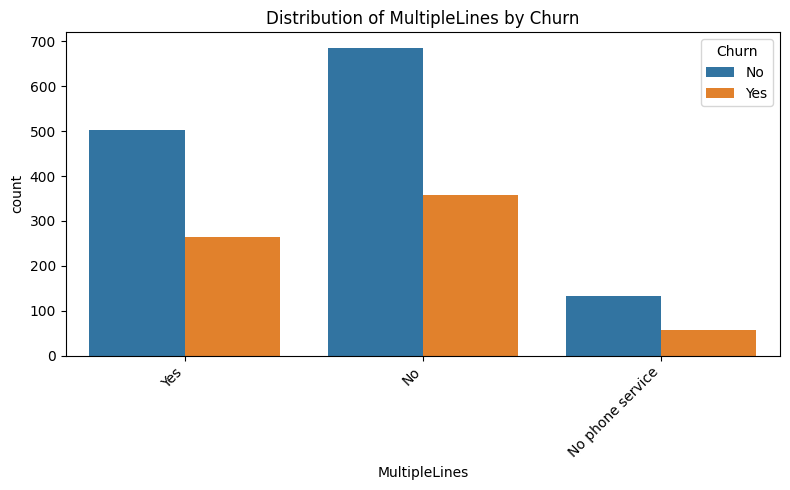

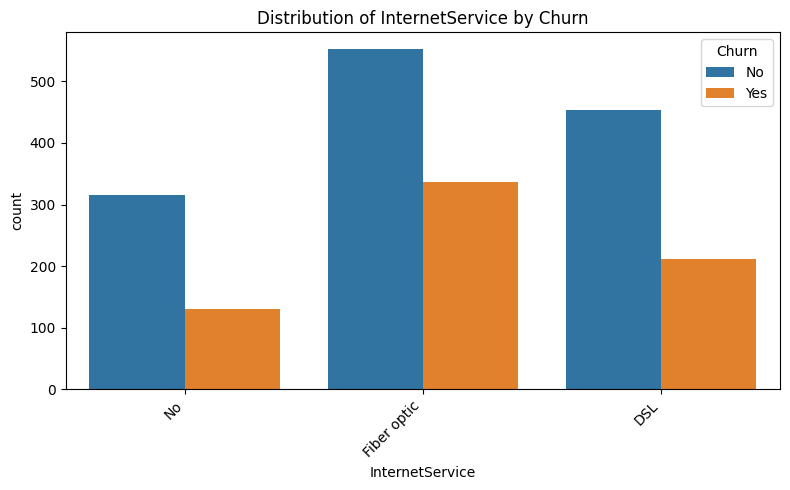

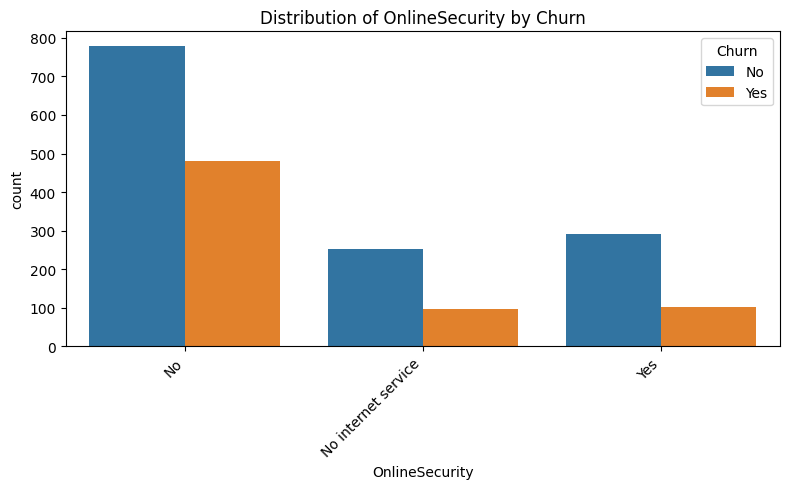

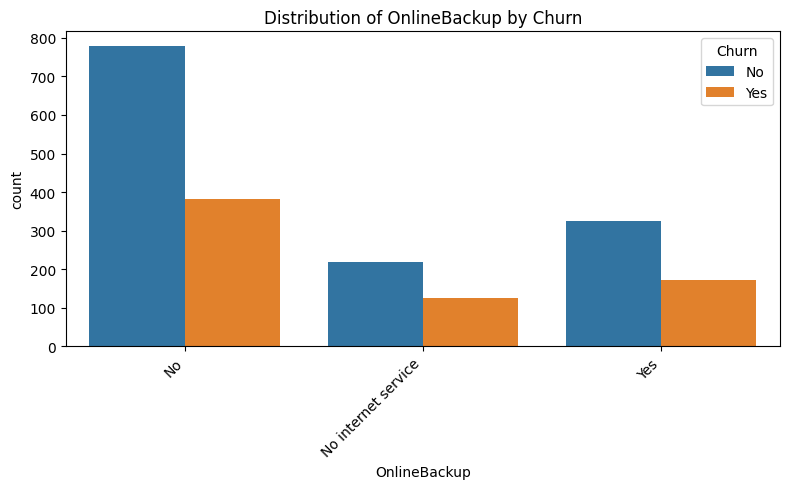

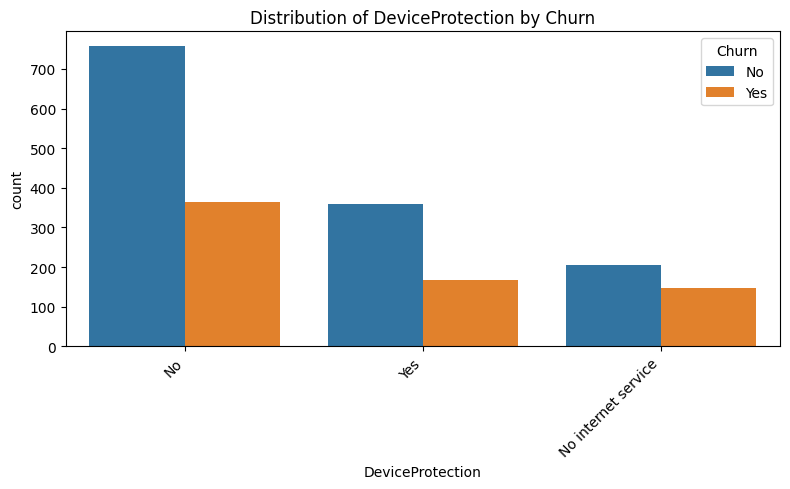

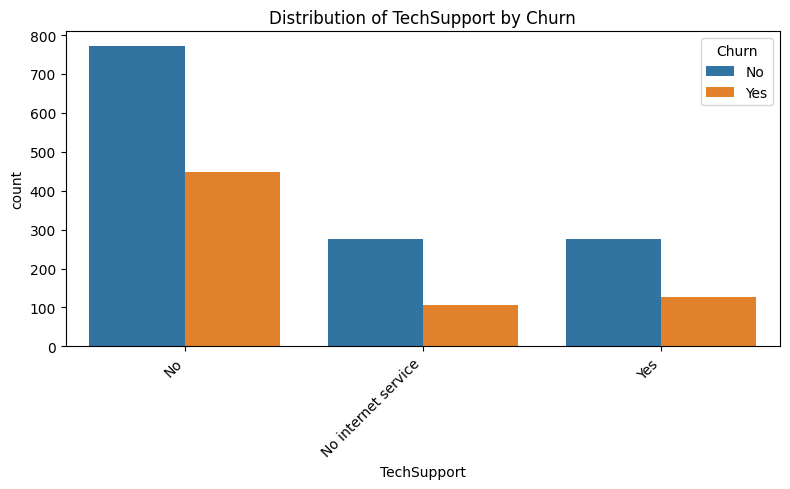

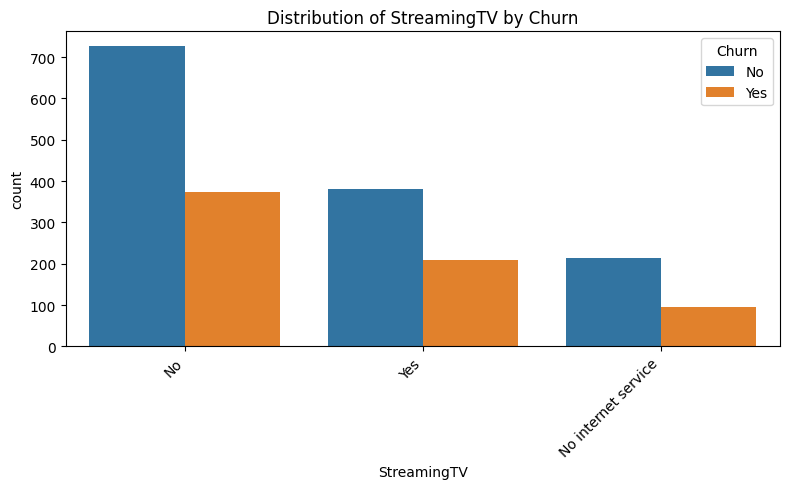

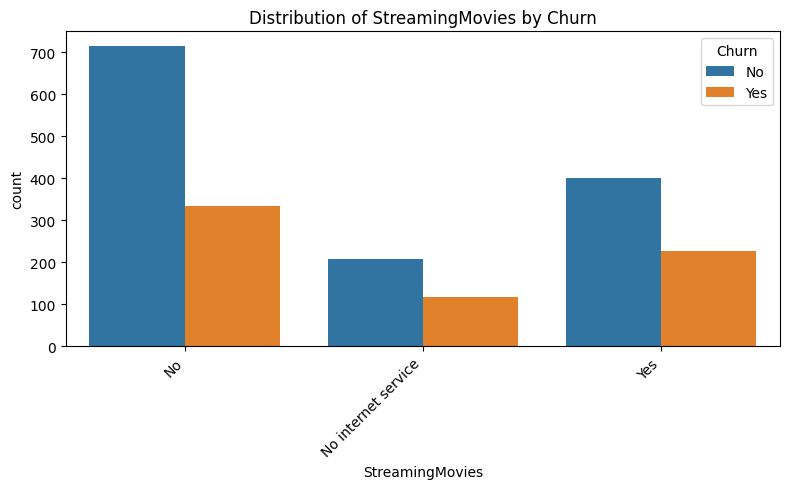

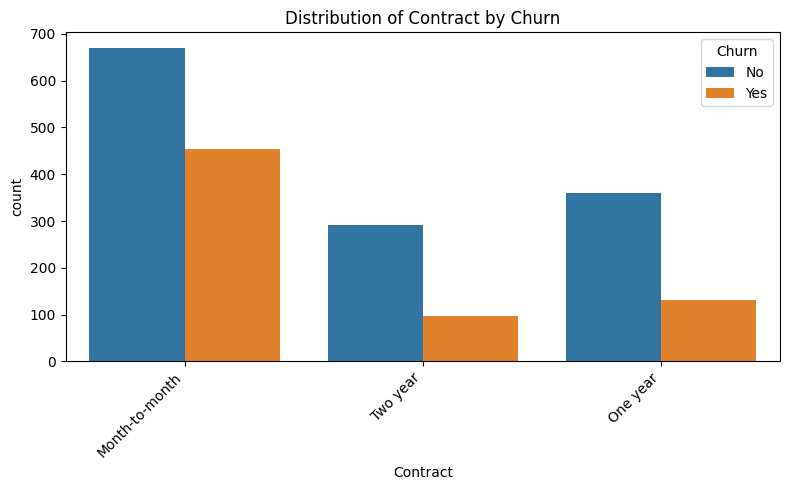

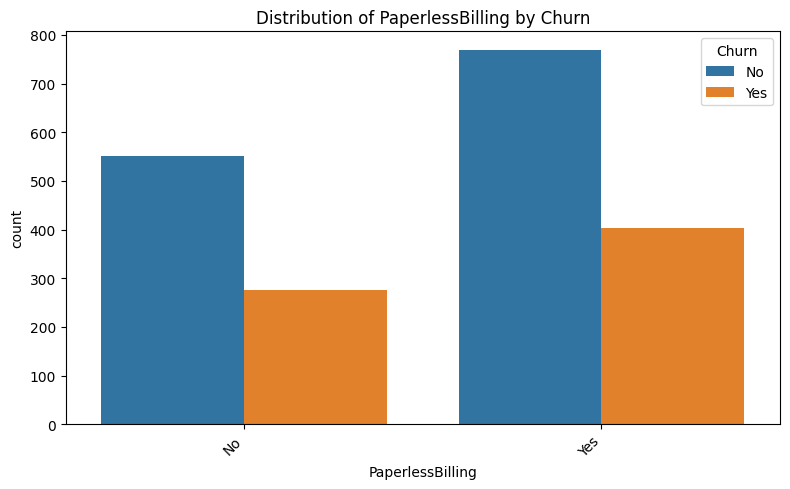

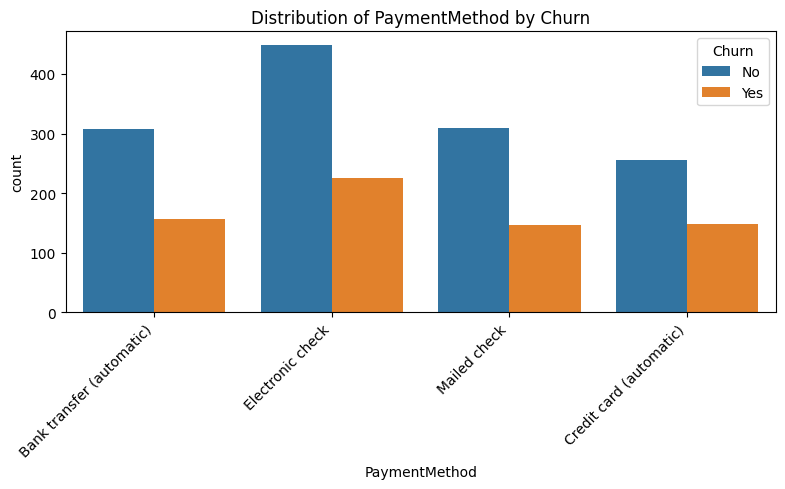

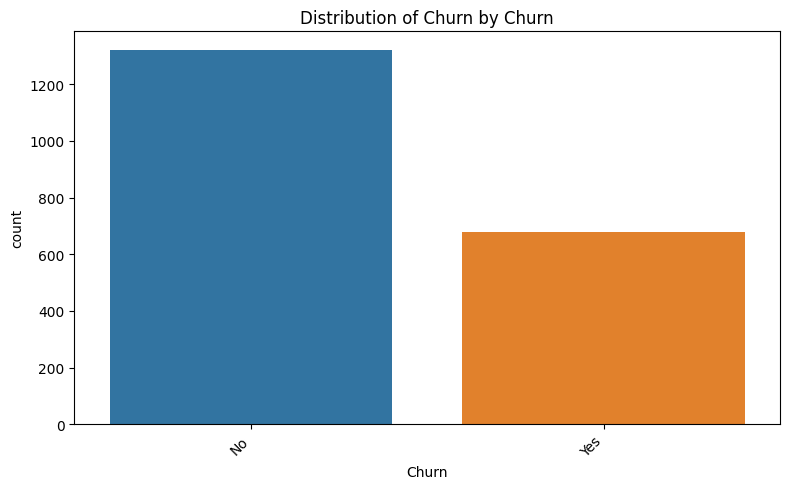

------------------------------

Correlation matrix for numerical features:


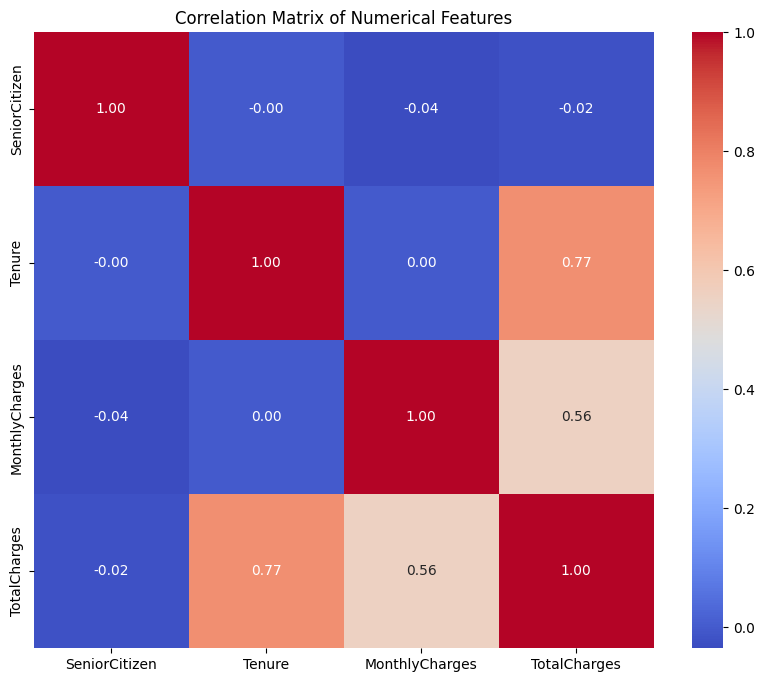

------------------------------

Identifying potential outliers using box plots:


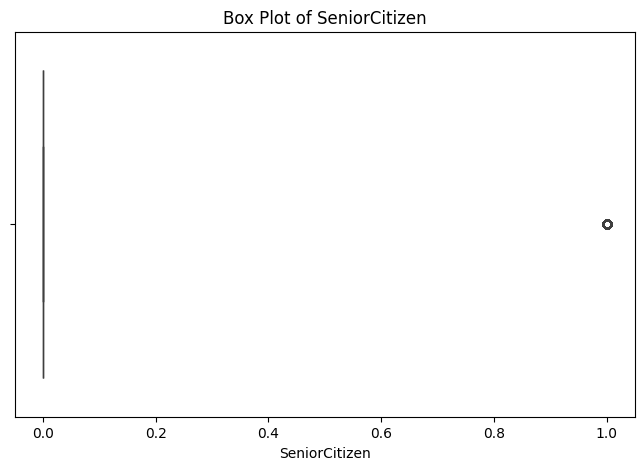

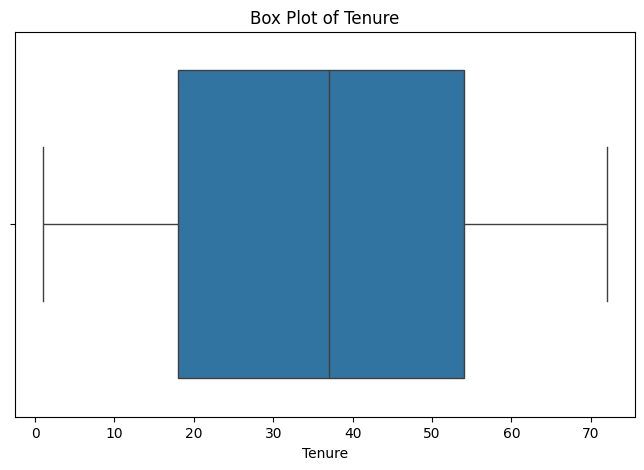

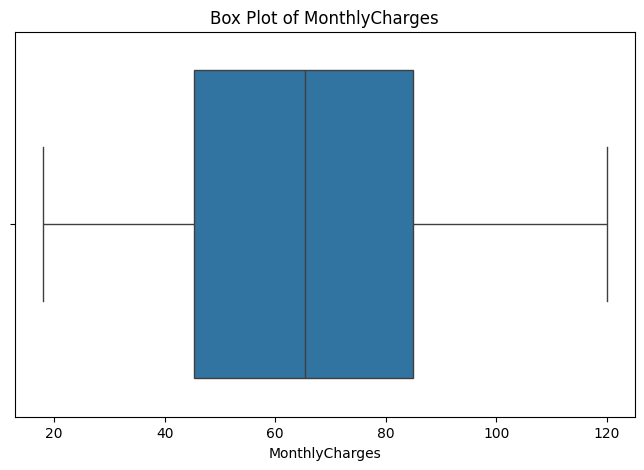

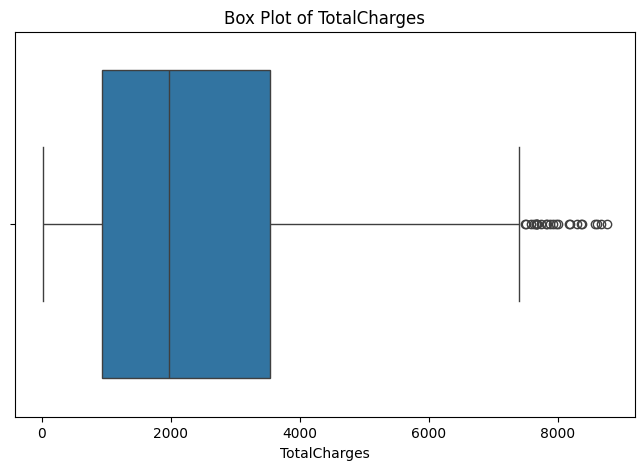

------------------------------

EDA complete. Summary statistics, missing values, distributions, and correlations have been examined.
Check the output and visualizations for insights into the data.


In [ ]:
# prompt: Perform Exploratory Data Analysis (EDA) to understand distributions, correlations, and identify missing values or outliers.

# Display the first few rows of the dataframe
print("First 5 rows of the dataset:")
print(df_customers.head())
print("-" * 30)

# Display the column names and their data types
print("Column names and data types:")
print(df_customers.info())
print("-" * 30)

# Display descriptive statistics for numerical columns
print("Descriptive statistics for numerical columns:")
print(df_customers.describe())
print("-" * 30)

# Check for missing values
print("Missing values per column:")
print(df_customers.isnull().sum())
print("-" * 30)

# Check the distribution of categorical variables
print("Value counts for categorical columns:")
for col in df_customers.select_dtypes(include='object').columns:
    if col not in ['CustomerID', 'TotalCharges']: # Exclude ID and potentially complex TotalCharges
        print(f"\nDistribution of {col}:")
        print(df_customers[col].value_counts(normalize=True))
        print("-" * 20)

# Visualize distributions of numerical features
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = df_customers.select_dtypes(include=np.number).columns.tolist()
# Exclude TotalCharges if it's still object before conversion
if 'TotalCharges' in numerical_cols:
    numerical_cols.remove('TotalCharges')

if 'TotalCharges' in df_customers.columns:
    try:
        df_customers['TotalCharges'] = pd.to_numeric(df_customers['TotalCharges'], errors='coerce')
        numerical_cols.append('TotalCharges')
    except:
        print("Could not convert TotalCharges to numeric for distribution plotting.")

print("\nVisualizing distributions of numerical features:")
df_customers[numerical_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()
print("-" * 30)

# Visualize distributions of categorical features
print("\nVisualizing distributions of categorical features:")
categorical_cols = df_customers.select_dtypes(include='object').columns.tolist()
if 'CustomerID' in categorical_cols:
    categorical_cols.remove('CustomerID')
if 'TotalCharges' in categorical_cols: # Remove if it wasn't converted
     categorical_cols.remove('TotalCharges')

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_customers, x=col, hue='Churn')
    plt.title(f'Distribution of {col} by Churn')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
print("-" * 30)


# Correlation matrix for numerical features
print("\nCorrelation matrix for numerical features:")
# Ensure numerical columns are numeric
df_numeric = df_customers[numerical_cols].copy()
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()
print("-" * 30)

# Identify potential outliers (using box plots for numerical features)
print("\nIdentifying potential outliers using box plots:")
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_customers[col])
    plt.title(f'Box Plot of {col}')
    plt.show()
print("-" * 30)

print("\nEDA complete. Summary statistics, missing values, distributions, and correlations have been examined.")
print("Check the output and visualizations for insights into the data.")

**Encoding categorical variables.**

In [ ]:
# prompt: our next task is to Encode categorical variables

# Identify categorical columns to encode (excluding Churn and CustomerID)
categorical_features = df_customers.select_dtypes(include='object').columns.tolist()
# Remove 'CustomerID' and 'Churn' from the list as they are not features for encoding
if 'CustomerID' in categorical_features:
    categorical_features.remove('CustomerID')
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')

print(f"Categorical features to encode: {categorical_features}")

# Apply one-hot encoding to the identified categorical features
# `drop_first=True` helps to avoid multicollinearity
df_customers_encoded = pd.get_dummies(df_customers, columns=categorical_features, drop_first=True)

print("\nDataFrame after One-Hot Encoding:")
print(df_customers_encoded.head())
print("-" * 30)
print("Shape of the encoded DataFrame:", df_customers_encoded.shape)

# Display the new columns created by one-hot encoding
encoded_cols = [col for col in df_customers_encoded.columns if '_' in col and any(cat_feat in col for cat_feat in categorical_features)]
print(f"\nNew columns created by encoding: {encoded_cols[:20]}...") # Print first 20 for brevity

Categorical features to encode: ['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

DataFrame after One-Hot Encoding:
  CustomerID  SeniorCitizen  Tenure  MonthlyCharges  TotalCharges Churn  \
0   CUST1000              0      30           69.55       2047.01    No   
1   CUST1001              0      11           48.08        522.42    No   
2   CUST1002              1      17           36.56        610.07    No   
3   CUST1003              0      26           79.72       2159.26    No   
4   CUST1004              0      23           70.42       1672.56    No   

   Gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  ...  \
0         True        False           False              True  ...   
1        False        False            True              True  ...   
2        False        False     

**Model Selection and Training:**

splitting data into training and testing

In [ ]:
# prompt: Split the data into training and testing sets.

from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
# We drop CustomerID as it's an identifier, and Churn is the target variable.
# Also drop the original categorical columns since we have their encoded versions.
X = df_customers_encoded.drop(['CustomerID', 'Churn'] + categorical_features, axis=1, errors='ignore') # errors='ignore' prevents error if columns are already dropped
y = df_customers_encoded['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) # Convert 'Yes'/'No' Churn to 1/0

# Handle potential remaining non-numeric columns (like TotalCharges if conversion failed)
X = X.apply(pd.to_numeric, errors='coerce')

# Handle potential NaN values created by coercion or existing NaNs (e.g., in TotalCharges)
# A simple strategy is to fill NaNs with the mean, but other methods like median or more sophisticated imputation are possible.
X = X.fillna(X.mean())


# Split the data into training and testing sets
# test_size: the proportion of the dataset to include in the test split
# random_state: ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("\nData split into training and testing sets:")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print("-" * 30)

print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True))



Data split into training and testing sets:
Shape of X_train: (1500, 30)
Shape of X_test: (500, 30)
Shape of y_train: (1500,)
Shape of y_test: (500,)
------------------------------

Class distribution in y_train:
Churn
0    0.660667
1    0.339333
Name: proportion, dtype: float64

Class distribution in y_test:
Churn
0    0.66
1    0.34
Name: proportion, dtype: float64


Train at least two different classification models (e.g., Logistic Regression, Random Forest, Gradient Boosting, SVM).

In [ ]:
# prompt: Train at least two different classification models (e.g., Logistic Regression, Random Forest, Gradient Boosting, SVM).or you can train all

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Initialize models
logreg_model = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
# SVM can be slow on larger datasets and might require feature scaling
# svm_model = SVC(probability=True, random_state=42) # probability=True is needed for ROC AUC

# List of models to train
models = {
    "Logistic Regression": logreg_model,
    "Random Forest": rf_model,
    # "Support Vector Machine": svm_model # Uncomment to include SVM
}

print("\nTraining models...")

# Train each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    print(f"{name} training complete.")
    print("-" * 20)

print("\nModel training finished.")



Training models...

Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training complete.
--------------------

Training Random Forest...
Random Forest training complete.
--------------------

Model training finished.


Perform hyperparameter tuning for the selected models.

In [ ]:
# prompt: Perform hyperparameter tuning for the selected models.

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grids for hyperparameter tuning
# Logistic Regression parameters
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Random Forest parameters
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# SVM parameters (can be computationally expensive)
# svm_param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto', 0.1, 1]
# }

print("\nPerforming hyperparameter tuning...")

tuned_models = {}

# Tune Logistic Regression
print("\nTuning Logistic Regression...")
grid_search_logreg = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000),
                                  logreg_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)
tuned_models["Logistic Regression"] = grid_search_logreg.best_estimator_
print(f"Best parameters for Logistic Regression: {grid_search_logreg.best_params_}")
print(f"Best ROC AUC score for Logistic Regression: {grid_search_logreg.best_score_:.4f}")
print("-" * 30)

# Tune Random Forest
print("\nTuning Random Forest...")
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
tuned_models["Random Forest"] = grid_search_rf.best_estimator_
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC AUC score for Random Forest: {grid_search_rf.best_score_:.4f}")
print("-" * 30)

# Tune SVM (uncomment to include)
# print("\nTuning Support Vector Machine...")
# grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42),
#                               svm_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_search_svm.fit(X_train, y_train)
# tuned_models["Support Vector Machine"] = grid_search_svm.best_estimator_
# print(f"Best parameters for Support Vector Machine: {grid_search_svm.best_params_}")
# print(f"Best ROC AUC score for Support Vector Machine: {grid_search_svm.best_score_:.4f}")
# print("-" * 30)

print("\nHyperparameter tuning complete. Tuned models stored in 'tuned_models' dictionary.")



Performing hyperparameter tuning...

Tuning Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'C': 100, 'solver': 'lbfgs'}
Best ROC AUC score for Logistic Regression: 0.6449
------------------------------

Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best ROC AUC score for Random Forest: 0.6009
------------------------------

Hyperparameter tuning complete. Tuned models stored in 'tuned_models' dictionary.


**Model Evaluation:**


Evaluating Tuned Models on the Test Set:

Evaluating Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.71      0.90      0.79       330
       Churn       0.59      0.28      0.38       170

    accuracy                           0.69       500
   macro avg       0.65      0.59      0.58       500
weighted avg       0.67      0.69      0.65       500


Confusion Matrix:
[[297  33]
 [123  47]]


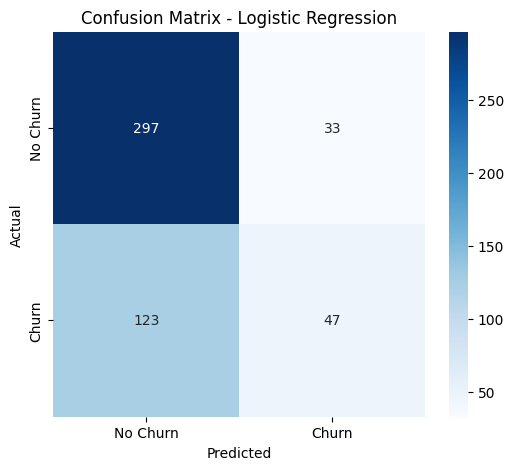


ROC AUC Score: 0.6543


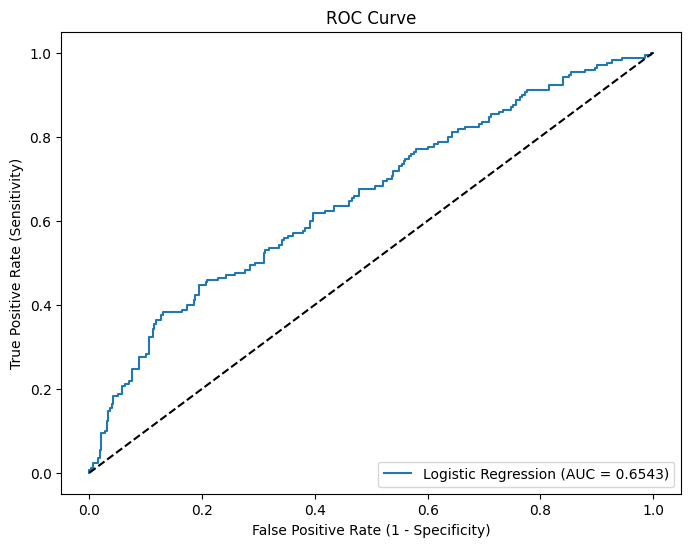


Average Precision (PR AUC): 0.5047


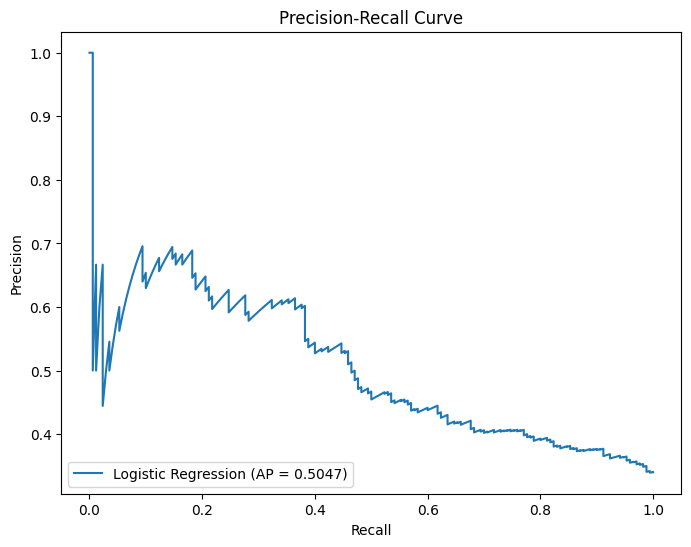

------------------------------

Evaluating Random Forest...

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.66      0.95      0.78       330
       Churn       0.41      0.06      0.11       170

    accuracy                           0.65       500
   macro avg       0.54      0.51      0.45       500
weighted avg       0.58      0.65      0.55       500


Confusion Matrix:
[[314  16]
 [159  11]]


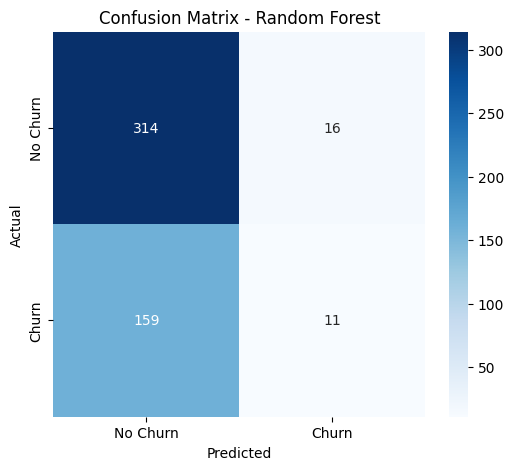


ROC AUC Score: 0.5995


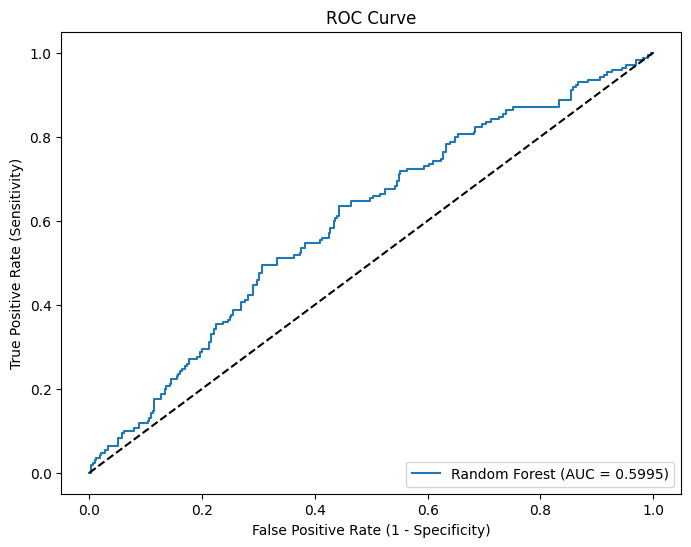


Average Precision (PR AUC): 0.4189


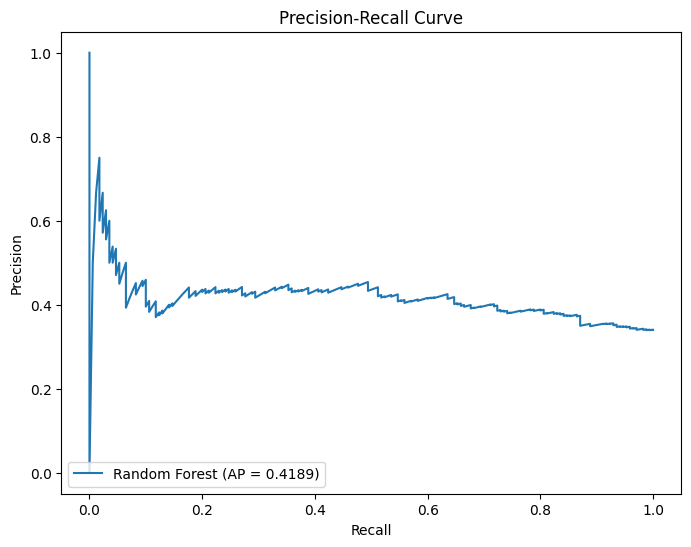

------------------------------

Model evaluation complete.
Review the classification reports, confusion matrices, ROC curves, and PR curves for each model.
Compare the metrics to determine which model performs best for predicting churn.


In [ ]:
# prompt: Evaluate models using appropriate metrics (e.g., Accuracy, Precision, Recall, F1-score, ROC-AUC).

print("\nEvaluating Tuned Models on the Test Set:")

# Evaluate each tuned model using various metrics
evaluation_results = {}

for name, model in tuned_models.items():
    print(f"\nEvaluating {name}...")

    # Make predictions
    y_pred = model.predict(X_test)

    # Get probability predictions (needed for ROC AUC and PR AUC)
    # Check if the model has predict_proba, otherwise skip probability-based metrics
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class (Churn = 1)
    else:
        y_pred_proba = None
        print(f"Warning: {name} does not support predict_proba. Skipping ROC AUC and PR AUC.")


    # Classification Report (Accuracy, Precision, Recall, F1-score)
    report = classification_report(y_test, y_pred, target_names=['No Churn', 'Churn'])
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    # Visualize Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


    # ROC AUC Score and Curve
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            print(f"\nROC AUC Score: {roc_auc:.4f}")

            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--') # Random guessing line
            plt.xlabel('False Positive Rate (1 - Specificity)')
            plt.ylabel('True Positive Rate (Sensitivity)')
            plt.title('ROC Curve')
            plt.legend(loc='lower right')
            plt.show()
        except ValueError as e:
            print(f"Could not compute ROC AUC for {name}: {e}")
            roc_auc = None

        # Precision-Recall Curve and AUC
        try:
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            average_precision = average_precision_score(y_test, y_pred_proba)
            print(f"\nAverage Precision (PR AUC): {average_precision:.4f}")

            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, label=f'{name} (AP = {average_precision:.4f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc='lower left')
            plt.show()
        except ValueError as e:
             print(f"Could not compute PR AUC for {name}: {e}")
             average_precision = None

    else:
        roc_auc = None
        average_precision = None


    # Store results (optional)
    evaluation_results[name] = {
        'classification_report': report,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'average_precision': average_precision,
        # Can add other metrics if desired
    }

    print("-" * 30)

print("\nModel evaluation complete.")
print("Review the classification reports, confusion matrices, ROC curves, and PR curves for each model.")
print("Compare the metrics to determine which model performs best for predicting churn.")

**Analyze feature importance from the best-performing model.**


Analyzing Feature Importance for the best model: Random Forest

Top 10 Most Important Features:
                           Feature  Importance
3                     TotalCharges    0.149001
1                           Tenure    0.147209
2                   MonthlyCharges    0.144482
24               Contract_One year    0.032301
10     InternetService_Fiber optic    0.028928
25               Contract_Two year    0.027968
26            PaperlessBilling_Yes    0.025972
13              OnlineSecurity_Yes    0.025640
28  PaymentMethod_Electronic check    0.024801
4                      Gender_Male    0.022168


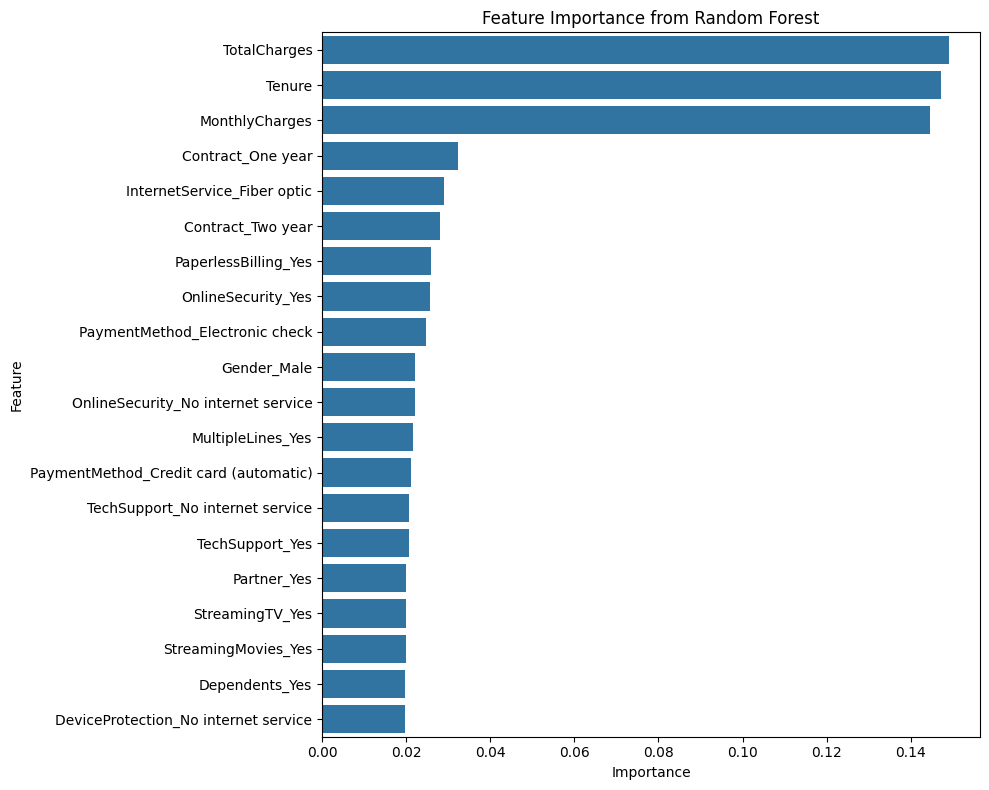

------------------------------
Feature importance analysis complete.


In [ ]:
# prompt: Analyze feature importance from the best-performing model.

# Assuming the best-performing model is 'Random Forest' based on previous evaluations (e.g., highest ROC AUC)
# You would replace 'Random Forest' with the actual name of your best model if it's different.

best_model_name = "Random Forest"
best_model = tuned_models.get(best_model_name)

if best_model is not None and hasattr(best_model, 'feature_importances_'):
    print(f"\nAnalyzing Feature Importance for the best model: {best_model_name}")

    # Get feature importances from the trained model
    importances = best_model.feature_importances_

    # Get the names of the features
    feature_names = X_train.columns

    # Create a DataFrame for easier visualization and sorting
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort the features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Print the top features
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))

    # Visualize feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20)) # Visualize top 20 features
    plt.title(f'Feature Importance from {best_model_name}')
    plt.tight_layout()
    plt.show()

elif best_model is None:
    print(f"\nModel '{best_model_name}' not found in tuned_models.")
elif not hasattr(best_model, 'feature_importances_'):
     print(f"\nModel '{best_model_name}' does not have 'feature_importances_'. Feature importance analysis is not directly supported for this model type (e.g., Logistic Regression, SVM).")
     print("For models without direct feature_importances_, you might use techniques like permutation importance or SHAP values.")

print("-" * 30)
print("Feature importance analysis complete.")

In [ ]:
# prompt: now save finalise dataset in csv file that i will use for rreporting in power bi:
# i mean dataset after processing and feature engineering

# Concatenate the original features with the predicted churn probability and class
# Create a copy of the original DataFrame before encoding to retain original columns for the final report
df_final_report = df_customers.copy()

# Get the best model (e.g., Random Forest) and make predictions on the *entire* dataset X (not just test set)
# This allows us to attach predictions to every customer row in the original data format
best_model_name = "Random Forest" # Or whichever model you chose as best
best_model = tuned_models.get(best_model_name)

if best_model is not None and hasattr(best_model, "predict_proba"):
    # Ensure X has the same columns and order as used for training/tuning
    # Re-apply encoding and handling NaNs to the entire dataset X
    X_all = df_customers.drop(['CustomerID', 'Churn'], axis=1)
    X_all_encoded = pd.get_dummies(X_all, columns=categorical_features, drop_first=True)

    # Align columns with the training data - this is crucial if the original data has rows
    # that resulted in different dummy columns than the training set (e.g., if a category
    # was only present in the test set).
    # Get columns from the training data used for the model
    train_cols = X_train.columns
    # Add missing columns to X_all_encoded and fill with 0
    missing_cols = set(train_cols) - set(X_all_encoded.columns)
    for c in missing_cols:
        X_all_encoded[c] = 0
    # Ensure the order of columns in X_all_encoded is the same as in train_cols
    X_all_encoded = X_all_encoded[train_cols]

    # Handle NaNs in the full dataset using the same strategy as training (e.g., mean)
    # Note: A more robust approach might use an imputer fitted on the training data.
    X_all_encoded = X_all_encoded.fillna(X_train.mean()) # Use mean from training data

    # Make predictions on the full, prepared dataset
    df_final_report['Predicted_Churn_Probability'] = best_model.predict_proba(X_all_encoded)[:, 1]
    df_final_report['Predicted_Churn_Class'] = best_model.predict(X_all_encoded)
    df_final_report['Predicted_Churn_Class'] = df_final_report['Predicted_Churn_Class'].apply(lambda x: 'Yes' if x == 1 else 'No')

    print("\nAdded predicted churn probability and class to the original DataFrame.")
    print(df_final_report[['CustomerID', 'Churn', 'Predicted_Churn_Probability', 'Predicted_Churn_Class']].head())


    # Save the final DataFrame to a CSV file for Power BI
    output_csv_filename = 'telecom_churn_report_data.csv'
    df_final_report.to_csv(output_csv_filename, index=False)

    print(f"\nFinal dataset for reporting saved to: {output_csv_filename}")

else:
    print(f"\nCould not find best model '{best_model_name}' or it does not support predict_proba.")
    print("Cannot create the report dataset with predictions.")

print("-" * 30)


Added predicted churn probability and class to the original DataFrame.
  CustomerID Churn  Predicted_Churn_Probability Predicted_Churn_Class
0   CUST1000    No                     0.318872                    No
1   CUST1001    No                     0.336725                    No
2   CUST1002    No                     0.388477                    No
3   CUST1003    No                     0.289437                    No
4   CUST1004    No                     0.284822                    No

Final dataset for reporting saved to: telecom_churn_report_data.csv
------------------------------
